In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.spatial.transform import Rotation
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import os, shutil
import sys

ModuleNotFoundError: No module named 'scipy'

In [2]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


### Performing PCA with an Undercomplete Linear Autoencoder

In [7]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.5)
autoencoder.compile(loss ='mse', optimizer = optimizer)

In [9]:
m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2] 

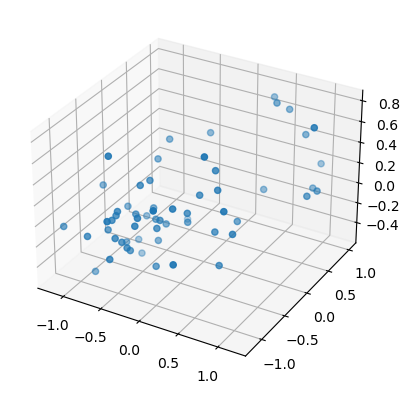

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2])

In [18]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X_train)

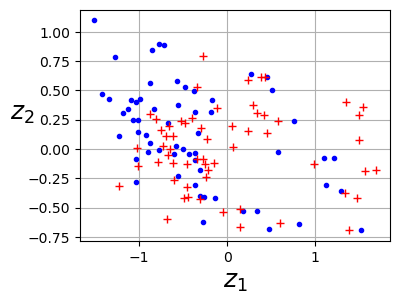

In [26]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.plot(X2D[:,0],X2D[:,1],'r+')
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

### Stacked Autoencoders

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [28]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")                   
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0238 - val_loss: 0.0181
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0170 - val_loss: 0.0166
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 8/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0144 - val_loss: 0.0147
Epoch 9/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 10/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.014

In [7]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1, 2))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
plt.show()

NameError: name 'stacked_ae' is not defined

In [40]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init= 'pca', learning_rate = 'auto', random_state = 42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 672us/step


/Users/chenxu/opt/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


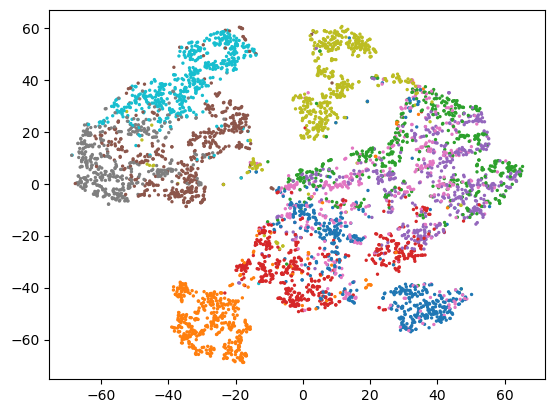

In [43]:
plt.scatter(X_valid_2D[:,0],X_valid_2D[:,1], c= y_valid, s= 2, cmap = 'tab10')

### Denoising Autoencoders

In [5]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.0292 - val_loss: 0.0216
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0222 - val_loss: 0.0198
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0209 - val_loss: 0.0190
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0201 - val_loss: 0.0184
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0196 - val_loss: 0.0178
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0193 - val_loss: 0.0176
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0190 - val_loss: 0.0173
Epoch 8/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0189 - val_loss: 0.0172
Epoch 9/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0187 - val_loss: 0.0170
Epoch 10/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.018

1/1 [==============================] - 0s 87ms/step


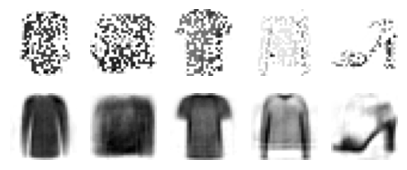

In [8]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
#save_fig("dropout_denoising_plot")
plt.show()

### Sparse Autoencoders

In [10]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# extra code – compiles and fits the model
sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.0280 - val_loss: 0.0190
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0171 - val_loss: 0.0157
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 8/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 9/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 10/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.011

1/1 [==============================] - 0s 82ms/step


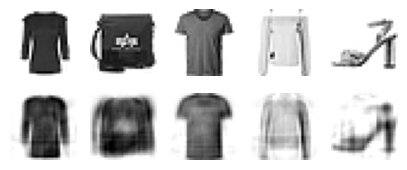

In [11]:
plot_reconstructions(sparse_l1_ae)
plt.show()